## <center> 04. From Rock Physics to Seismic Simulations</center>
<center><i>Author: M Steel</i></center>

### <center> 1. Amplitude Versus Offset Analysis</center>

Conventional seismic interpretation implies picking and tracking laterally consistent seismic reflectors for the purpose of mapping geological structures, stratigraphy and reservoir architecture (Avseth et al., 2020). Quantitative seismic interpretation (QSI) looks at variations in seismic characteristics (e.g., impedance, amplitude, polarization) and changes in elastic moduli. QSI developments such as amplitude variations with offset (AVO) can be analysed for purposes such as fluid indication or lithology detection. Hammond (1974) first noted that bright-spot amplitude anomalies in seismic impedance ($I = \rho V$) could be associated with hydrocarbon traps.

The basis of the AVO technique is built off of the Zoeppritz (1919) equations (Figure 1). The Zoeppritz equations describe the partitioning of energy when a seismic plane wave interacts with an acoustic interface. In a general case, for a non-zero incident wave, the incoming plane wave partitions into four waves (Figure 2):

- The reflected P-wave ($R_{P}$)
- The reflected S-wave ($R_{S}$)
- The transmitted P-wave ($T_{P}$)
- The transmitted S-wave ($T_{S}$)

<center><img src = "./notebook_figures/zoeppritz.png"></img></center>
<center><b>Figure 1:</b> <i>The Zoeppritz equations</i></center>

<center><img src = "./notebook_figures/zoeppritz_diagram.jpg"></img></center>
<center><b>Figure 2:</b> <i>Schematic representation of wave partitioning at an acoustic boundary</i></center>

In practice, solving the Zoeppritz equations is a highly non-linear process so often linear approximations are used to make the process more computationally efficient. In my way, I use the generalised expression of Schoenberg and Protazio (1990) for anisotropic reflection coefficients to express the influence of anisotropy on AVO. I will demonstrate this utility in the code below.

In [4]:
import mantis_core.interface as manIT
import mantis_core.utilities as manUT
top_properties = {"Vp": 3.82, "Vs": 2.06, "Rho": 2.56} # Endurance overburden
bot_properties = {"Vp": 3.89, "Vs": 2.18, "Rho": 2.31} # Endurance reservoir

layer1 = manIT.SchoenbergProtazio(
    Cij=manUT.VtoCij(**top_properties),
    density=top_properties["Rho"],
)

layer2 = manIT.SchoenbergProtazio(
    Cij=manUT.VtoCij(**bot_properties),
    density=bot_properties["Rho"],
)

layer2VTI = manIT.SchoenbergProtazio(
    Cij=manUT.thomsen_vti(**bot_properties, epsilon=0.1, delta=0.1, gamma=.1),
    density=bot_properties["Rho"],
)

layer2HTI = manIT.SchoenbergProtazio(
    Cij=manUT.interchange_y_and_z(
        manUT.thomsen_vti(**bot_properties, epsilon=0.1, delta=0.1, gamma=0.1)
    ),
    density=bot_properties["Rho"],
)

layerrotated2HTI = manIT.SchoenbergProtazio(
    Cij=manUT.azimuthal_rotation(manUT.interchange_y_and_z(
        manUT.thomsen_vti(**bot_properties, epsilon=0.1, delta=0.1, gamma=0.1)
    ), theta = 90),
    density=bot_properties["Rho"],
)


/tmp/ipykernel_25238/2234099780.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  reflectivities[key][i]  = rt(horizontal_slowness=[0., s])[0][0,0]


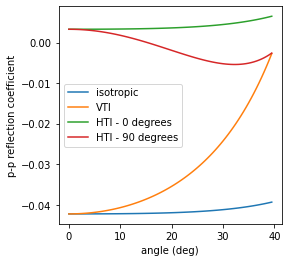

In [5]:

import numpy as np
angles = np.arange(0.,40, 0.5)
rads = np.deg2rad(angles)
slownesses = [manUT.incidence_angle_to_slowness(incidence_angle=r, Vp=top_properties["Vp"]) for r in rads]

reflectivities = {}
labels = {"Isotropic": layer2, "VTI": layer2VTI, "HTI - 0 degrees":layer2HTI, "HTI - 90 degrees": layerrotated2HTI}

for key, val in labels.items():
    reflectivities[key] = np.empty(len(angles))
    rt = manIT.ReflectionTransmissionMatrix.sp_init(spUp=layer1, spDown=val)
    for i, s in enumerate(slownesses):
        reflectivities[key][i]  = rt(horizontal_slowness=[0., s])[0][0,0]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(angles, reflectivities["Isotropic"], label="isotropic")
ax.plot(angles, reflectivities["VTI"], label="VTI")
ax.plot(angles, reflectivities["HTI - 0 degrees"], label="HTI - 0 degrees")
ax.plot(angles, reflectivities["HTI - 90 degrees"], label = "HTI - 90 degrees")
ax.set_xlabel("angle (deg)")
ax.set_ylabel("p-p reflection coefficient")
ax.legend()

### <center>2. 2D Finite-Difference Simulations</center>

To be able to assess the implication of my rock physics models on the geophysical response, I run 2D finite-difference simulations. The finite-difference method is a stable way of discretising and imposing boundary conditions on partial differential equations. I use this method to simulate the propagation of a seismic wave through a defined Earth model. The finite-difference code I use is a staggered grid, 2D, anisotropic, viscoelastic representation.

> Note: The finite-difference code has recently been updated so I will present figures taken from the previous code iteration

For the previous finite-difference code runs, I used the following parameters:

- Earth model built from Endurance well 42/25d-3 and averaging per lithological formation
- Created 3 models, a <u>baseline</u> model with no changes from the in-situ values, an <u>elastic</u> model where I added 10% uniformly-mixed CO2 to 20 m below the seal-reservoir boundary and a <u>viscoelastic</u> model which included the altered elastic values but included a parametrised SLS model of $$omega$_{ref} = log(45)$ and $Q = 8$
- The finite-difference grid was 2001*1001 points representing 4000 m length by 2000 m depth
- The simulated source was a Gaussian pulse
- I set up two receiver arrays, one a line of geophones coincident to the top of the available data at 807.5 m depth and a set of 9 VSP receivers with 252 m horizontal spacing and 1372 m depth

The primary outputs of the finite-difference simulations are traces (in pressure, vertical motion and horizontal motion) and snapshots (in time). Of primary interest was comparing the different traces at particular VSPs between the three defined models (Figure 3) and primary and multiples in the VSPs as proxy AVO observations (Figure 4).

<center><img src = "./notebook_figures/traces.png"></img></center>
<center><b>Figure 3:</b> <i>Stacked traces for baseline, elastic and viscoelastic models</i></center>

<center><img src = "./notebook_figures/sls_vsp.png"></img></center>
<center><b>Figure 4:</b> <i>Primaries for the viscoelastic model</i></center>